# Tokenization

In [1]:
import re
import spacy
import numpy as np
import pandas as pd
from datasets import load_dataset

from dataclasses import dataclass
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from typing import List, Dict, Tuple
from collections import Counter, defaultdict

## Data Loading

In [2]:
def load_translation_dataset():
    print("Loading Tatoeba en-ru...")
    try:
        dataset = load_dataset("Helsinki-NLP/tatoeba", lang1="en", lang2="ru", trust_remote_code=True)
        
    except Exception as e:
        print(f"Error while loading dataset: {e}")
        raise
    
    print("\nDataset structure:")
    print(dataset)
    
    print("\nData sample:")
    for i in range(2):
        print(f"EN: {dataset['train'][i]['translation']['en']}")
        print(f"RU: {dataset['train'][i]['translation']['ru']}\n")

    return dataset

In [3]:
dataset = load_translation_dataset()

Loading Tatoeba en-ru...


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

tatoeba.py:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 523656
    })
})

Data sample:
EN: For once in my life I'm doing a good deed... And it is useless.
RU: Один раз в жизни я делаю хорошее дело... И оно бесполезно.

EN: Let's try something.
RU: Давайте что-нибудь попробуем!



## Data Analyze

In [4]:
def analyze_dataset(dataset, n_samples: int = 1000):
    samples = dataset['train'].select(range(n_samples))
    
    en_lengths = [len(s['translation']['en'].split()) for s in samples]
    ru_lengths = [len(s['translation']['ru'].split()) for s in samples]
    
    print(f"Analysis based on first {n_samples} samples:")
    print(f"\nEnglish sentences:")
    print(f"Average length: {np.mean(en_lengths):.1f} words")
    print(f"Max length: {max(en_lengths)} words")
    print(f"Min length: {min(en_lengths)} words")
    
    print(f"\nRussian sentences:")
    print(f"Average length: {np.mean(ru_lengths):.1f} words")
    print(f"Max length: {max(ru_lengths)} words")
    print(f"Min length: {min(ru_lengths)} words")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(en_lengths, bins=30)
    plt.title('English Sentence Lengths')
    plt.xlabel('Words')
    
    plt.subplot(1, 2, 2)
    sns.histplot(ru_lengths, bins=30)
    plt.title('Russian Sentence Lengths')
    plt.xlabel('Words')
    
    plt.tight_layout()
    plt.show()
    
    return max(max(en_lengths), max(ru_lengths))

Analysis based on first 1000 samples:

English sentences:
Average length: 7.2 words
Max length: 30 words
Min length: 1 words

Russian sentences:
Average length: 6.2 words
Max length: 28 words
Min length: 1 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


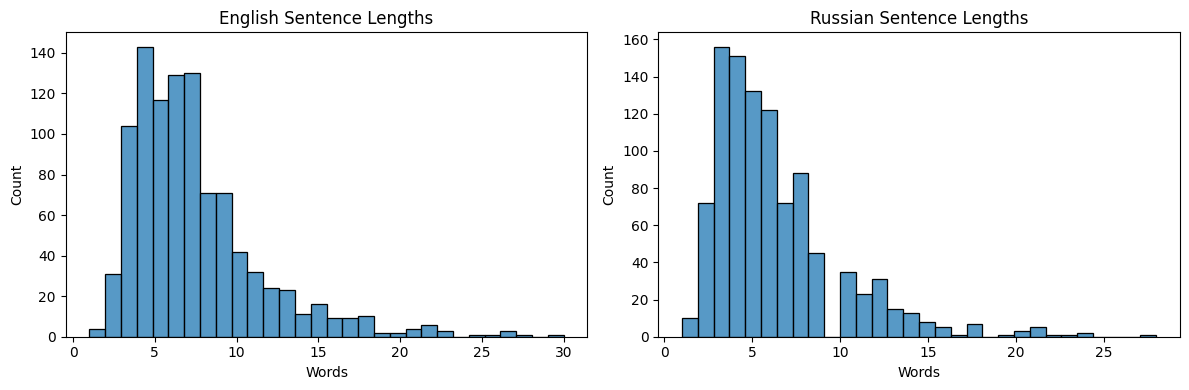

In [5]:
max_sentence_length = analyze_dataset(dataset)

## Токенизация

In [6]:
@dataclass
class BaseTokenizer:
    language: str
    vocab_size: int
    min_freq: int = 2
    special_tokens: List[str] = None
    
    def __post_init__(self):
        self.special_tokens = self.special_tokens or ["<PAD>", "<UNK>", "<BOS>", "<EOS>"]
        self.token2id = {token: idx for idx, token in enumerate(self.special_tokens)}
        self.id2token = {idx: token for idx, token in enumerate(self.special_tokens)}
    
    def preprocess_text(self, text: str) -> List[str]:
        tokens = re.findall(r"\w+[\w']*|[\"'.,!?;:-]", text.lower())
        return tokens
    
    def get_stats(self, examples: List[str]) -> Counter:
        counter = Counter()
        for text in examples:
            tokens = self.preprocess_text(text)
            counter.update(tokens)
        return counter

In [7]:
en_tokenizer = BaseTokenizer(language='en', vocab_size=32000)
ru_tokenizer = BaseTokenizer(language='ru', vocab_size=32000)

In [8]:
def analyze_token_statistics(dataset, tokenizer: BaseTokenizer, n_samples: int = 1000):
    samples = dataset['train'].select(range(n_samples))
    texts = [s['translation'][tokenizer.language] for s in samples]
    
    stats = tokenizer.get_stats(texts)
    
    print(f"\nToken statistics for {tokenizer.language}:")
    print(f"Total unique tokens: {len(stats)}")
    print("\nTop 10 most frequent tokens:")
    for token, count in stats.most_common(10):
        print(f"{token}: {count}")
    
    return stats

In [9]:
en_stats = analyze_token_statistics(dataset, en_tokenizer)
ru_stats = analyze_token_statistics(dataset, ru_tokenizer)


Token statistics for en:
Total unique tokens: 1335

Top 10 most frequent tokens:
.: 815
i: 351
you: 322
to: 280
the: 231
?: 185
a: 164
,: 160
": 146
is: 139

Token statistics for ru:
Total unique tokens: 2061

Top 10 most frequent tokens:
.: 806
,: 442
я: 294
не: 287
?: 185
это: 150
что: 149
ты: 124
!: 114
в: 112


## PBE токенизация

In [10]:
@dataclass
class BPETokenizer(BaseTokenizer):
    def __post_init__(self):
        super().__post_init__()
        self.merges = {}
        self.vocab = set(self.special_tokens)
        
    def get_pairs(self, word: List[str]) -> List[Tuple[str, str]]:
        return [(word[i], word[i+1]) for i in range(len(word)-1)]
    
    def train(self, texts: List[str], num_merges: int):
        word_freqs = defaultdict(int)
        for text in texts:
            tokens = self.preprocess_text(text)
            for token in tokens:
                chars = list(token)
                word = ' '.join(chars) 
                word_freqs[word] += 1
                self.vocab.update(chars)
        
        print(f"Training BPE tokenizer for {self.language}...")
        for i in tqdm(range(num_merges)):
            # Count pair frequencies
            pair_freqs = defaultdict(int)
            for word, freq in word_freqs.items():
                symbols = word.split()
                pairs = self.get_pairs(symbols)
                for pair in pairs:
                    pair_freqs[pair] += freq
            
            if not pair_freqs:
                break
                
            # Find best pair
            best_pair = max(pair_freqs.items(), key=lambda x: x[1])[0]
            
            # Create new merged token
            new_token = ''.join(best_pair)
            self.merges[best_pair] = new_token
            self.vocab.add(new_token)
            
            # Update word frequencies
            new_word_freqs = defaultdict(int)
            for word, freq in word_freqs.items():
                symbols = word.split()
                i = 0
                new_symbols = []
                while i < len(symbols)-1:
                    if i < len(symbols)-1 and (symbols[i], symbols[i+1]) == best_pair:
                        new_symbols.append(new_token)
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                if i == len(symbols)-1:
                    new_symbols.append(symbols[-1])
                new_word = ' '.join(new_symbols)
                new_word_freqs[new_word] = freq
            word_freqs = new_word_freqs
            
            # Update token mappings
            if new_token not in self.token2id:
                idx = len(self.token2id)
                self.token2id[new_token] = idx
                self.id2token[idx] = new_token
            
            if (i + 1) % 1000 == 0:
                print(f"Vocabulary size: {len(self.token2id)}")
    
    def tokenize(self, text: str) -> List[int]:
        tokens = self.preprocess_text(text)
        result = [self.token2id['<BOS>']]
        
        for token in tokens:
            symbols = list(token)
            
            # Merge according to learned merges
            while len(symbols) > 1:
                pairs = self.get_pairs(symbols)
                pair_to_merge = None
                for pair in pairs:
                    if pair in self.merges:
                        pair_to_merge = pair
                        break
                if not pair_to_merge:
                    break
                    
                # Apply merge
                i = 0
                new_symbols = []
                while i < len(symbols):
                    if i < len(symbols)-1 and (symbols[i], symbols[i+1]) == pair_to_merge:
                        new_symbols.append(self.merges[pair_to_merge])
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                symbols = new_symbols
            
            # Add token IDs
            for symbol in symbols:
                if symbol in self.token2id:
                    result.append(self.token2id[symbol])
                else:
                    result.append(self.token2id['<UNK>'])
        
        result.append(self.token2id['<EOS>'])
        return result

In [11]:
en_bpe = BPETokenizer(language='en', vocab_size=32000)
ru_bpe = BPETokenizer(language='ru', vocab_size=32000)

n_samples = 80000 
train_samples = dataset['train'].select(range(n_samples))
en_texts = [s['translation']['en'] for s in train_samples]
ru_texts = [s['translation']['ru'] for s in train_samples]

en_bpe.train(en_texts, num_merges=3000)
ru_bpe.train(ru_texts, num_merges=3000)

# Проверка размера словаря
print(f"English vocabulary size: {len(en_bpe.token2id)}")
print(f"Russian vocabulary size: {len(ru_bpe.token2id)}")

Training BPE tokenizer for en...


  0%|          | 0/3000 [00:00<?, ?it/s]

Training BPE tokenizer for ru...


  0%|          | 0/3000 [00:00<?, ?it/s]

English vocabulary size: 3004
Russian vocabulary size: 3004


In [12]:
def test_tokenization(text: str, tokenizer: BPETokenizer):
    print(f"\nOriginal text: {text}")
    
    token_ids = tokenizer.tokenize(text)
    print(f"Token IDs: {token_ids}")
    
    tokens = [tokenizer.id2token[id] for id in token_ids]
    print(f"Tokens: {tokens}")
    
    return token_ids

In [13]:
en_sample = dataset['train'][0]['translation']['en']
ru_sample = dataset['train'][0]['translation']['ru']

print("English tokenization:")
en_tokens = test_tokenization(en_sample, en_bpe)

print("\nRussian tokenization:")
ru_tokens = test_tokenization(ru_sample, ru_bpe)

English tokenization:

Original text: For once in my life I'm doing a good deed... And it is useless.
Token IDs: [2, 166, 1, 577, 6, 51, 418, 150, 939, 1, 203, 127, 21, 1, 1, 1, 57, 24, 8, 158, 903, 383, 1, 3]
Tokens: ['<BOS>', 'fo', '<UNK>', 'once', 'in', 'my', 'life', "i'm", 'doing', '<UNK>', 'good', 'de', 'ed', '<UNK>', '<UNK>', '<UNK>', 'and', 'it', 'is', 'us', 'el', 'ess', '<UNK>', '<EOS>']

Russian tokenization:

Original text: Один раз в жизни я делаю хорошее дело... И оно бесполезно.
Token IDs: [2, 541, 273, 106, 1, 772, 1, 172, 1, 1, 2058, 172, 1, 1, 1, 1, 1, 29, 1, 1668, 323, 235, 11, 1, 3]
Tokens: ['<BOS>', 'од', 'ин', 'раз', '<UNK>', 'жизни', '<UNK>', 'дел', '<UNK>', '<UNK>', 'хорошее', 'дел', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'он', '<UNK>', 'бес', 'пол', 'ез', 'но', '<UNK>', '<EOS>']


## Подготовка батчей

In [14]:
def prepare_batch(batch: List[Dict], 
                 src_tokenizer: BPETokenizer, 
                 tgt_tokenizer: BPETokenizer,
                 max_length: int):
    src_texts = [item['translation']['en'] for item in batch]
    tgt_texts = [item['translation']['ru'] for item in batch]

    src_tokens = [src_tokenizer.tokenize(text) for text in src_texts]
    tgt_tokens = [tgt_tokenizer.tokenize(text) for text in tgt_texts]
    
    src_padded = []
    tgt_padded = []
    src_masks = []
    tgt_masks = []
    
    for src, tgt in zip(src_tokens, tgt_tokens):
        if len(src) > max_length:
            src_pad = src[:max_length]
            src_mask = [1] * max_length
        else:
            src_pad = src + [src_tokenizer.token2id['<PAD>']] * (max_length - len(src))
            src_mask = [1] * len(src) + [0] * (max_length - len(src))
        
        if len(tgt) > max_length:
            tgt_pad = tgt[:max_length]
            tgt_mask = [1] * max_length
        else:
            tgt_pad = tgt + [tgt_tokenizer.token2id['<PAD>']] * (max_length - len(tgt))
            tgt_mask = [1] * len(tgt) + [0] * (max_length - len(tgt))
        
        src_padded.append(src_pad)
        tgt_padded.append(tgt_pad)
        src_masks.append(src_mask)
        tgt_masks.append(tgt_mask)
    
    return {
        'src_tokens': np.array(src_padded),
        'tgt_tokens': np.array(tgt_padded),
        'src_mask': np.array(src_masks),
        'tgt_mask': np.array(tgt_masks)
    }


In [15]:
test_samples = dataset['train'].select(range(5))
prepared_data = prepare_batch(test_samples, en_bpe, ru_bpe, max_length=64)

print("Prepared batch shapes:")
for key, value in prepared_data.items():
    print(f"{key}: {value.shape}")

print("\nExample source tokens:")
print(prepared_data['src_tokens'][0])
print("\nCorresponding mask:")
print(prepared_data['src_mask'][0])

Prepared batch shapes:
src_tokens: (5, 64)
tgt_tokens: (5, 64)
src_mask: (5, 64)
tgt_mask: (5, 64)

Example source tokens:
[  2 166   1 577   6  51 418 150 939   1 203 127  21   1   1   1  57  24
   8 158 903 383   1   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Corresponding mask:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
def verify_bpe_tokenization(tokenizer: BPETokenizer, text: str):
    """Подробная проверка процесса токенизации"""
    print(f"Original text: {text}")
    
    base_tokens = tokenizer.preprocess_text(text)
    print(f"\nBase tokenization: {base_tokens}")
    
    print(f"\nNumber of merges learned: {len(tokenizer.merges)}")
    print("Sample merges (first 5):")
    for pair, merged in list(tokenizer.merges.items())[:5]:
        print(f"{pair} -> {merged}")
    
    print(f"\nVocabulary size: {len(tokenizer.token2id)}")
    print("Sample vocabulary items (first 10):")
    for token, idx in list(tokenizer.token2id.items())[:10]:
        print(f"{token}: {idx}")
    
    tokens = tokenizer.tokenize(text)
    decoded = [tokenizer.id2token[id] for id in tokens]
    
    print(f"\nFinal tokenization:")
    print(f"Token IDs: {tokens}")
    print(f"Decoded tokens: {decoded}")

print("Testing English tokenizer:")
verify_bpe_tokenization(en_bpe, dataset['train'][0]['translation']['en'])

Testing English tokenizer:
Original text: For once in my life I'm doing a good deed... And it is useless.

Base tokenization: ['for', 'once', 'in', 'my', 'life', "i'm", 'doing', 'a', 'good', 'deed', '.', '.', '.', 'and', 'it', 'is', 'useless', '.']

Number of merges learned: 3000
Sample merges (first 5):
('h', 'e') -> he
('t', 'he') -> the
('i', 'n') -> in
('o', 'u') -> ou
('i', 's') -> is

Vocabulary size: 3004
Sample vocabulary items (first 10):
<PAD>: 0
<UNK>: 1
<BOS>: 2
<EOS>: 3
he: 4
the: 5
in: 6
ou: 7
is: 8
re: 9

Final tokenization:
Token IDs: [2, 166, 1, 577, 6, 51, 418, 150, 939, 1, 203, 127, 21, 1, 1, 1, 57, 24, 8, 158, 903, 383, 1, 3]
Decoded tokens: ['<BOS>', 'fo', '<UNK>', 'once', 'in', 'my', 'life', "i'm", 'doing', '<UNK>', 'good', 'de', 'ed', '<UNK>', '<UNK>', '<UNK>', 'and', 'it', 'is', 'us', 'el', 'ess', '<UNK>', '<EOS>']


## Hugging Face

In [17]:
from transformers import AutoTokenizer

def prepare_data_with_hf(
    dataset,
    model_name: str = "Helsinki-NLP/opus-mt-en-ru",
    max_length: int = 128,
    batch_size: int = 32
):
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    def preprocess_function(examples):
        source_texts = [item['en'] for item in examples['translation']]
        target_texts = [item['ru'] for item in examples['translation']]
        
        source_encoding = tokenizer(
            source_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='np'
        )
        
        target_encoding = tokenizer(
            target_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='np'
        )
        
        return {
            'input_ids': source_encoding['input_ids'],
            'attention_mask': source_encoding['attention_mask'],
            'labels': target_encoding['input_ids'],
            'decoder_attention_mask': target_encoding['attention_mask']
        }
    
    processed_dataset = dataset['train'].map(
        preprocess_function,
        batched=True,
        batch_size=batch_size,
        remove_columns=dataset['train'].column_names
    )
    
    return processed_dataset, tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
processed_data, hf_tokenizer = prepare_data_with_hf(dataset)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/523656 [00:00<?, ? examples/s]